In [1]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline 

sns.set()
sns.set_style("white")

In [3]:
dateparser = lambda x: pd.datetime.strptime(x, '%Y-%m-%d %H:%M:%S')            
eng=pd.read_csv('takehome_user_engagement.csv',parse_dates=['time_stamp']
                , date_parser=dateparser)

                

In [4]:
#creating date column
eng['date']=eng.time_stamp.dt.date

In [5]:
# assigning 1 to every day that user logged in
eng2=pd.DataFrame(eng.groupby(['user_id','date'])['visited'].min().reset_index())
eng2['date'] = pd.to_datetime(eng2['date'], format='%Y-%m-%d')

In [6]:
#couting how many days user logged in 7 window period (if there is less than three days - assign NaN and drop it)
eng3=pd.DataFrame(eng2.groupby(['user_id'])[['date','visited']].rolling('7d',on='date',min_periods = 3).sum()).dropna()

In [7]:
eng3.reset_index(inplace=True)

In [8]:
adopted=list(eng3.user_id.unique())

In [9]:
user=pd.read_csv('takehome_users.csv',encoding='latin-1')

In [10]:
user['adopted_user'] = user.object_id.apply(lambda x: x in adopted)

In [11]:
user = user.fillna(0)

In [12]:
user['invited']=user['invited_by_user_id'].apply(lambda x : int(bool(x)))
user['any_session']=user['last_session_creation_time'].apply(lambda x : int(bool(x)))

In [13]:
df = pd.DataFrame(user.groupby('creation_source')['adopted_user'].value_counts())

In [14]:
df = df.unstack(level=1)

There were only 1602 adopted users identified out 12000 number of total users in the dataset. That is only around 13% of the whole data set.

Main factors taken into account:

- if a user opted to a mailing list (yes/no)
- if they are on a regular mailing list (yes/no)
- if they were invited by someone or not (no invitation user id was interpreted as the user was not invited by anyone)
- if the user ever logged in after account creation (no last session creation time was interpreted as the user never logged in after account creation) 
- the source of account creation:
    - one can see on the graphs below that. generally. users invited to join -personal projects has the smallest ratio of adopted users to non adopted users 
       

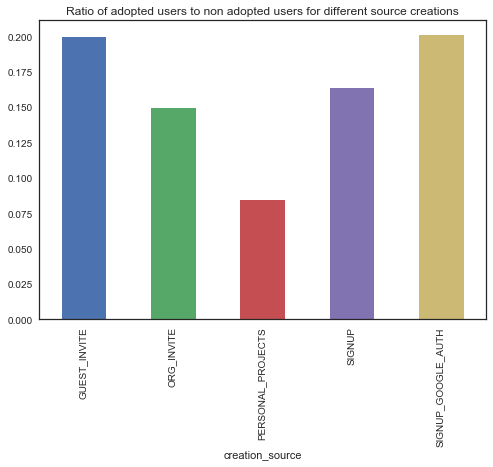

In [15]:
df['ratio']=df.iloc[:,1]/df.iloc[:,0]
df['ratio'].plot(kind='bar');
plt.title('Ratio of adopted users to non adopted users for different source creations');

In [16]:
user_d=pd.get_dummies(user,drop_first=True, columns = ['creation_source'])

In [84]:
X = user_d[['opted_in_to_mailing_list',
       'enabled_for_marketing_drip',
        'creation_source_ORG_INVITE',
       'creation_source_PERSONAL_PROJECTS', 'creation_source_SIGNUP',
       'creation_source_SIGNUP_GOOGLE_AUTH','invited','any_session']]
y=user_d.adopted_user

Random Forest was chosen for future adoption prediction since it is easy to interpret and doesn't require much tuning. Since the dataset is highly unbalanced, SMOTE technique was used to balance the classes.


- The accuracy of the model is around 65% which a somehow better random selection. 
- The recall for adopted users is very good (99%) however only 3!% for non adopted users. Precision is much higher for non - adpoted users (98%) and only 59% for adopted users. 
- The feature importance study of the trained random forest revealed that user should log in at least once to be considered for adoption, which seems reasonable inference. If that condition is met, the study revealed that invitation from an organization might potentially create more adpoted users. 

In [74]:
#creating training and testing sets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report,accuracy_score


[[ 963 2120]
 [  41 3115]]
             precision    recall  f1-score   support

      False       0.96      0.31      0.47      3083
       True       0.60      0.99      0.74      3156

avg / total       0.77      0.65      0.61      6239

Accuracy:  0.6536303894854945
                                    importance
feature                                       
any_session                              0.886
creation_source_PERSONAL_PROJECTS        0.051
invited                                  0.018
creation_source_ORG_INVITE               0.014
creation_source_SIGNUP_GOOGLE_AUTH       0.012
opted_in_to_mailing_list                 0.008
enabled_for_marketing_drip               0.006
creation_source_SIGNUP                   0.004


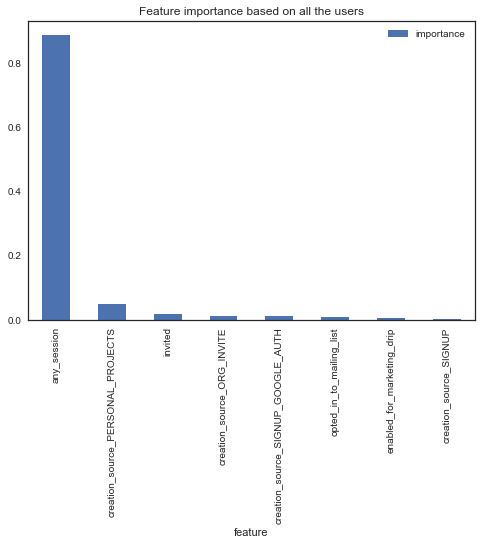

In [85]:
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_sample(X, y)
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.3)
model= RandomForestClassifier()
model.fit(X_train,y_train)
predictions = model.predict(X_test)
print(confusion_matrix(y_test,predictions));
print(classification_report(y_test,predictions));
print("Accuracy: ", accuracy_score(y_test,predictions));
importances = pd.DataFrame({'feature':X.columns,'importance':np.round(model.feature_importances_,3)})
importances = importances.sort_values('importance',ascending=False).set_index('feature')
 
print( importances);
importances.plot.bar();
plt.title('Feature importance based on all the users');

In [87]:
#users who logged in at least once
user_d2=user_d[user_d['any_session']==True]
X = user_d2[['opted_in_to_mailing_list',
       'enabled_for_marketing_drip',
        'creation_source_ORG_INVITE',
       'creation_source_PERSONAL_PROJECTS', 'creation_source_SIGNUP',
       'creation_source_SIGNUP_GOOGLE_AUTH','invited']]
y=user_d2.adopted_user

[[1429  698]
 [1280  926]]
             precision    recall  f1-score   support

      False       0.53      0.67      0.59      2127
       True       0.57      0.42      0.48      2206

avg / total       0.55      0.54      0.54      4333

Accuracy:  0.5435033464112624
                                    importance
feature                                       
creation_source_ORG_INVITE               0.255
creation_source_SIGNUP                   0.201
invited                                  0.162
enabled_for_marketing_drip               0.105
creation_source_PERSONAL_PROJECTS        0.095
opted_in_to_mailing_list                 0.093
creation_source_SIGNUP_GOOGLE_AUTH       0.089


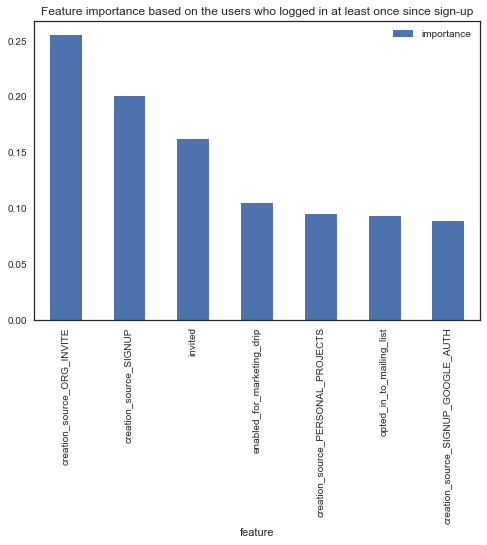

In [91]:
X = user_d[user_d['any_session']==True][['opted_in_to_mailing_list',
       'enabled_for_marketing_drip',
        'creation_source_ORG_INVITE',
       'creation_source_PERSONAL_PROJECTS', 'creation_source_SIGNUP',
       'creation_source_SIGNUP_GOOGLE_AUTH','invited']]
sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_sample(X, y)
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.3)
model= RandomForestClassifier()
model.fit(X_train,y_train)
predictions = model.predict(X_test)
print(confusion_matrix(y_test,predictions));
print(classification_report(y_test,predictions));
print("Accuracy: ", accuracy_score(y_test,predictions));
importances = pd.DataFrame({'feature':X.columns,'importance':np.round(model.feature_importances_,3)})
importances = importances.sort_values('importance',ascending=False).set_index('feature')
 
print( importances);
importances.plot.bar();
plt.title('Feature importance based on the users who logged in at least once since sign-up');


Final Conclusions:

- It is worth to analyze why there only 13% adopted users. If only three logins are required to consider adoption, then there is clearly so issues with the product that the users opt out. It is worth to analyze further through surveys/focus groups to see why the product doesn't work.
- If at least one session creation is important for a future user adoption, more analysis could be done about to understand how much time needs to pass until the user is considered inactive, and plan a strategy out it to understand that behavior. 
- Additionally, more investigation could be done about users who joined through an organization invitation to understand how those organizations use the product and their feedback. 